In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn

In [2]:
join = os.path.join
base_path = "/home/anmol/projects/pytorch_classification_template/datafolder/saved"

In [3]:
query_path = join(base_path, "query_actv")
val_path = join(base_path, "val_actv")

In [4]:
for file in glob.glob(join(query_path, "*")):
    if "activationMap.pkl" in file:
        query_act = pickle.load(open(file, 'rb'))
    elif "gt.pkl" in file:
        gt_q = pickle.load(open(file, 'rb'))
    elif 'pred.pkl' in file:
        pred_q = pickle.load(open(file, 'rb'))
    else:
        shape_q = pickle.load(open(file, 'rb'))
        
for file in glob.glob(join(val_path, "*")):
    if "activationMap.pkl" in file:
        val_act = pickle.load(open(file, 'rb'))
    elif "gt.pkl" in file:
        gt_v = pickle.load(open(file, 'rb'))
    elif 'pred.pkl' in file:
        pred_v = pickle.load(open(file, 'rb'))
    else:
        shape_v = pickle.load(open(file, 'rb'))

In [5]:
def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

In [6]:
shape_v

[torch.Size([64, 64, 55, 55]),
 torch.Size([64, 192, 27, 27]),
 torch.Size([64, 384, 13, 13]),
 torch.Size([64, 256, 13, 13]),
 torch.Size([64, 256, 13, 13]),
 torch.Size([64, 4096]),
 torch.Size([64, 4096]),
 torch.Size([64, 2])]

In [7]:
val_act[3].shape

torch.Size([600, 256, 13, 13])

In [8]:
val_im_act_matrix = torch.zeros([600, 204864], dtype=torch.float32)

for im in range(0, 600):
    for k in range(1, 3):
        # 139968 + 64896
        if k == 1:
            val_im_act_matrix[im, 0:139968] = flatten(val_act[k][im,...])
        elif k == 2:
            val_im_act_matrix[im, 139968:] = flatten(val_act[k][im,...])

We now have a matrix with rows M = number of validation images, and columns N = number of neurons (total 204864 for 2 conv layers)

In [9]:
val_im_act_matrix.shape

torch.Size([600, 204864])

In [10]:
gt_v.shape

torch.Size([600])

In [11]:
pred_v.shape

torch.Size([600, 2])

The predictions are NOT SOFTMAX probabilities, so convert them

In [12]:
softmax = nn.Softmax()
pred_v = softmax(pred_v)

/home/anmol/softwares/anaconda3/envs/pt10/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Convert the prediction probabilities to class labels

In [13]:
_, pred_v_cl = torch.max(pred_v, 1)

Get the correct and incorrect prediction "ground truth". This ground truth will contain -1 if the image was incorrectly predicted, and +1 if it was correctly predicted. 

In [14]:
new_gt_for_training = torch.ones([pred_v.shape[0]], dtype=torch.int32)
correct = incorrect = 0
for i in range(0, pred_v.shape[0]):
    if pred_v_cl[i] != gt_v[i]:
        incorrect += 1
        new_gt_for_training[i] = -1
    else:
        correct += 1
        new_gt_for_training[i] = 1

In [15]:
print("Correct predictions = {}, incorrect predictions = {}".format(correct, incorrect))

Correct predictions = 459, incorrect predictions = 141


Convert these tensors to numpy for compatibility with sklearn

In [16]:
X = val_im_act_matrix.numpy()
Y = new_gt_for_training.numpy()

We  have the training data now. X and Y. Let's do some machine learning

In [17]:
X.shape

(600, 204864)

In [18]:
Y.shape

(600,)

In [19]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = svm.SVC(C=1, kernel='rbf', gamma="scale", verbose=5, probability=True)
# clf = GridSearchCV(clf, parameters,  n_jobs=-1, verbose=5, cv=4)

In [20]:
clf.fit(X, Y)

[LibSVM]

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=5)

Now let's test our trained model and see if it can figure out whether a query image was correctly or incorrectly classified

In [21]:
query_act[0].shape[0]

150

In [22]:
q_im_act_matrix = torch.zeros([query_act[0].shape[0], 204864], dtype=torch.float32)

for im in range(0, query_act[0].shape[0]):
    for k in range(1, 3):
        # 139968 + 64896
        if k == 1:
            q_im_act_matrix[im, 0:139968] = flatten(query_act[k][im,...])
        elif k == 2:
            q_im_act_matrix[im, 139968:] = flatten(query_act[k][im,...])

In [23]:
q_im_act_matrix.shape

torch.Size([150, 204864])

In [24]:
gt_q.shape

torch.Size([150])

In [25]:
pred_q = softmax(pred_q)

/home/anmol/softwares/anaconda3/envs/pt10/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [26]:
pred_q_pr, pred_q_cl = torch.max(pred_q, 1)

In [27]:
new_gt_for_testing_q = torch.ones([pred_q.shape[0]], dtype=torch.int32)
correct = incorrect = 0
for i in range(0, pred_q.shape[0]):
    if pred_q_cl[i] != gt_q[i]:
        incorrect += 1
        new_gt_for_testing_q[i] = -1
    else:
        correct += 1
        new_gt_for_testing_q[i] = 1

In [28]:
print("Correct predictions = {}, incorrect predictions = {}".format(correct, incorrect))

Correct predictions = 110, incorrect predictions = 40


In [29]:
X_test = q_im_act_matrix.numpy()
Y_test = new_gt_for_testing_q.numpy()

Time to test!

In [31]:
clf.score(X_test, Y_test)

0.7266666666666667

In [32]:
proba_X_test = clf.predict_proba(X_test)

In [33]:
proba_X_test

array([[0.18332367, 0.81667633],
       [0.28052116, 0.71947884],
       [0.22221671, 0.77778329],
       [0.21077242, 0.78922758],
       [0.25869683, 0.74130317],
       [0.17432284, 0.82567716],
       [0.17627138, 0.82372862],
       [0.27428204, 0.72571796],
       [0.31227537, 0.68772463],
       [0.20147814, 0.79852186],
       [0.21990049, 0.78009951],
       [0.49327161, 0.50672839],
       [0.20833524, 0.79166476],
       [0.26226945, 0.73773055],
       [0.27215972, 0.72784028],
       [0.33308206, 0.66691794],
       [0.32704725, 0.67295275],
       [0.24875534, 0.75124466],
       [0.18974403, 0.81025597],
       [0.26192471, 0.73807529],
       [0.2794224 , 0.7205776 ],
       [0.18645367, 0.81354633],
       [0.61236613, 0.38763387],
       [0.16762168, 0.83237832],
       [0.22801836, 0.77198164],
       [0.20947057, 0.79052943],
       [0.31032041, 0.68967959],
       [0.21151249, 0.78848751],
       [0.42503679, 0.57496321],
       [0.54945189, 0.45054811],
       [0.

In [74]:
gt_q

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [35]:
import numpy as np

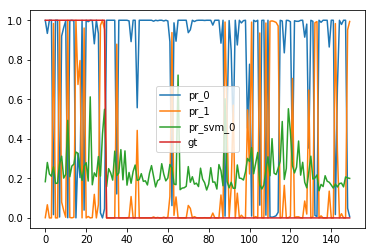

In [37]:
x = np.array(range(0,  150))
plt.plot(x, pred_q.numpy()[:, 0], label='pr_0')
plt.plot(x, pred_q.numpy()[:, 1], label='pr_1')
plt.plot(x, proba_X_test[:, 0], label='pr_svm_0')
plt.plot(x, gt_q.numpy(), label='gt')
plt.legend()
plt.show()

In [80]:
pred_q

tensor([[9.9886e-01, 1.1360e-03],
        [9.3343e-01, 6.6572e-02],
        [1.0000e+00, 1.0319e-07],
        [1.0000e+00, 6.7845e-10],
        [1.6554e-02, 9.8345e-01],
        [9.9982e-01, 1.8214e-04],
        [9.9982e-01, 1.7829e-04],
        [4.7465e-03, 9.9525e-01],
        [9.1992e-01, 8.0075e-02],
        [9.6239e-01, 3.7609e-02],
        [9.9674e-01, 3.2574e-03],
        [8.5501e-04, 9.9915e-01],
        [9.9765e-01, 2.3511e-03],
        [9.9968e-01, 3.2495e-04],
        [9.9676e-01, 3.2430e-03],
        [2.8391e-04, 9.9972e-01],
        [3.2492e-01, 6.7508e-01],
        [2.0396e-01, 7.9604e-01],
        [9.9982e-01, 1.8105e-04],
        [3.9349e-02, 9.6065e-01],
        [9.9992e-01, 7.5100e-05],
        [9.9258e-01, 7.4244e-03],
        [9.9999e-01, 1.4114e-05],
        [9.9843e-01, 1.5682e-03],
        [8.8081e-01, 1.1919e-01],
        [1.0000e+00, 2.8632e-06],
        [9.3198e-01, 6.8018e-02],
        [2.5660e-02, 9.7434e-01],
        [9.8866e-06, 9.9999e-01],
        [4.652